Episode: 0, Step: 400, Counter: 0, Total reward: -1037.837646484375, final state: tensor([ 0.0899, -0.4513, -0.1255,  0.4507])
Episode: 100, Step: 400, Counter: 3, Total reward: -657.3291625976562, final state: tensor([-0.0658, -1.0770,  0.1420, -0.4159])


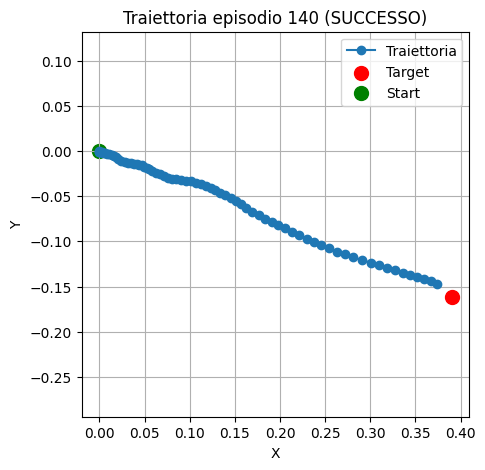

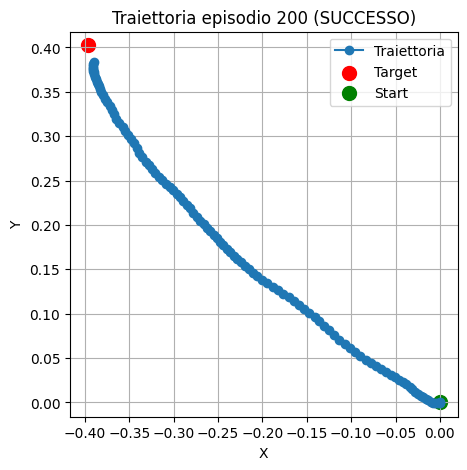

Episode: 200, Step: 109, Counter: 20, Total reward: 480.1873779296875, final state: tensor([-0.3897,  0.3853, -0.3969,  0.4026])


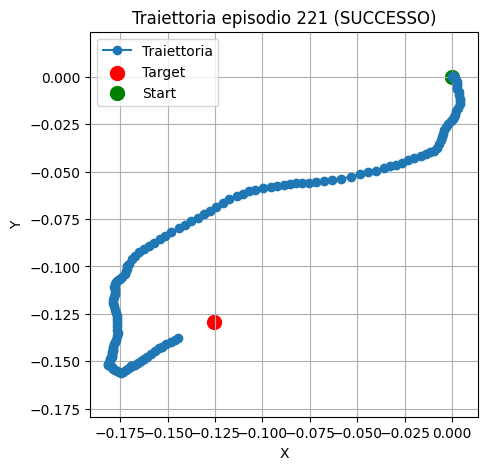

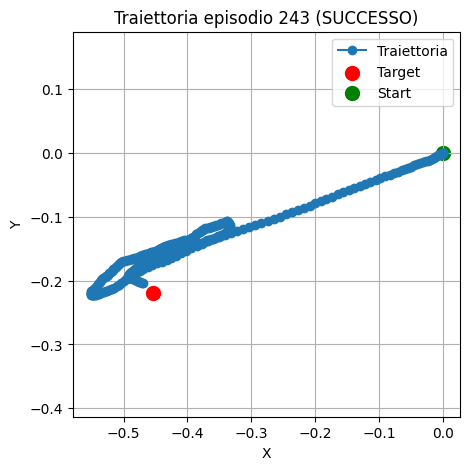

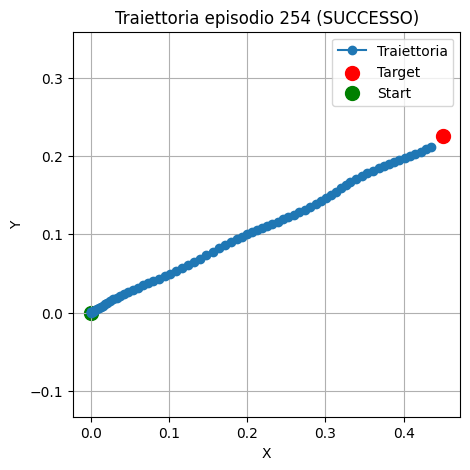

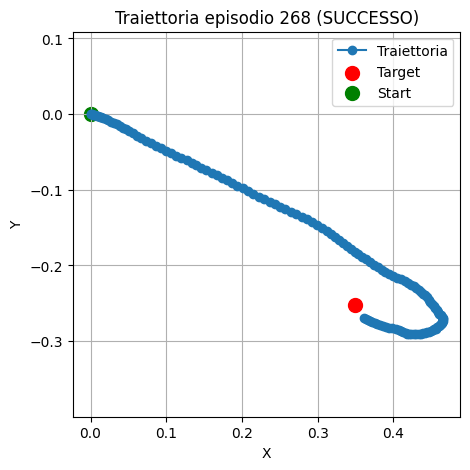

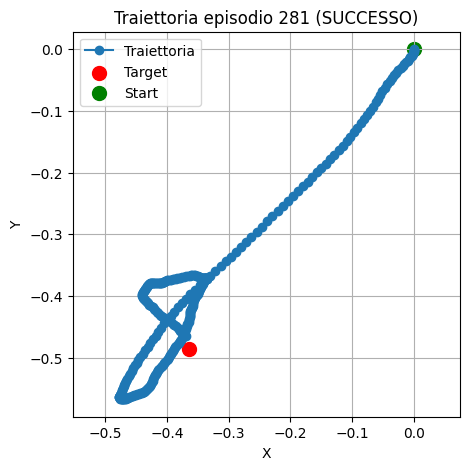

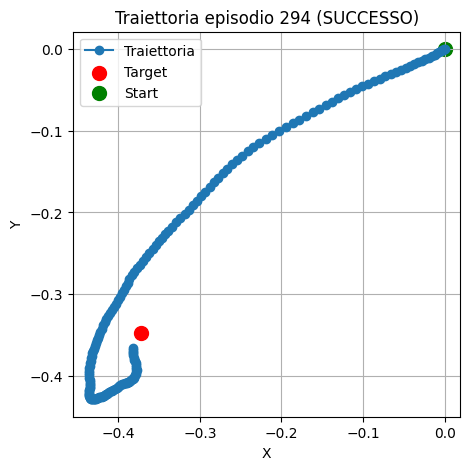

Episode: 300, Step: 218, Counter: 86, Total reward: 381.09088134765625, final state: tensor([-0.3388, -0.2391, -0.3311, -0.2214])


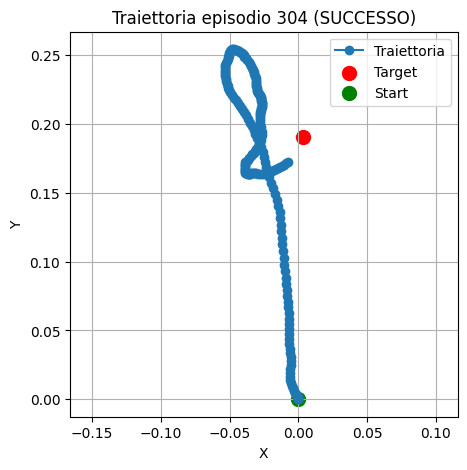

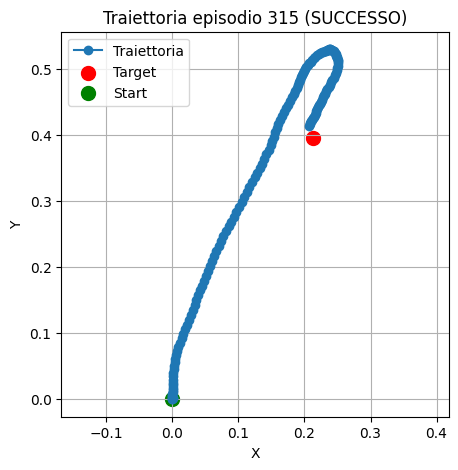

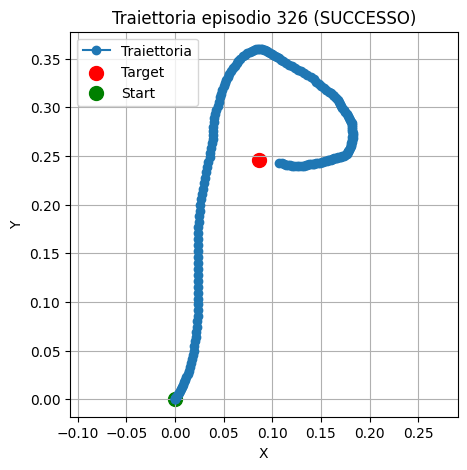

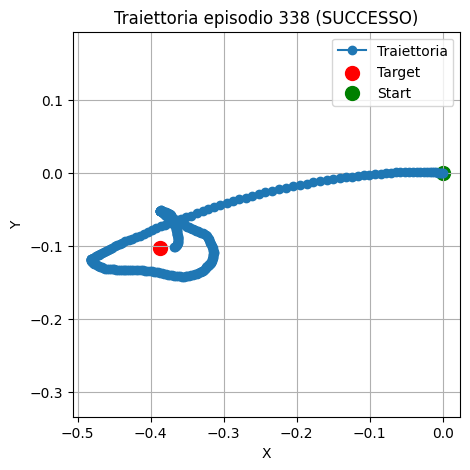

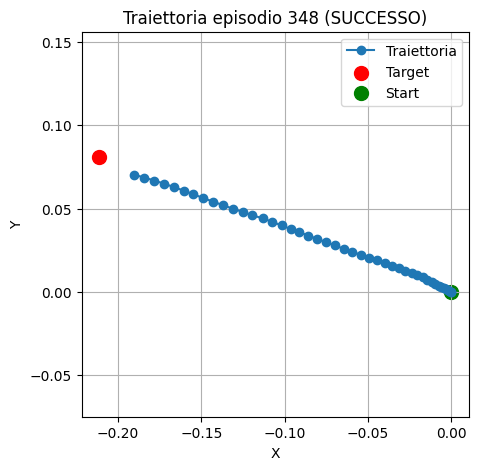

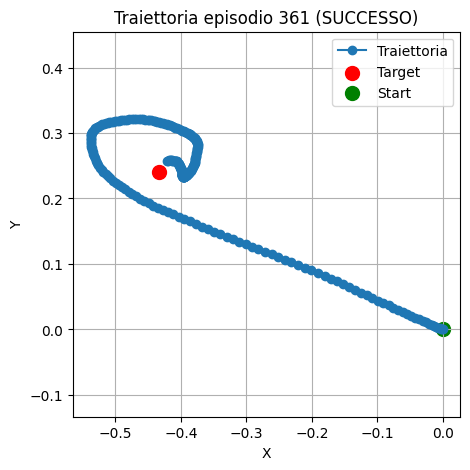

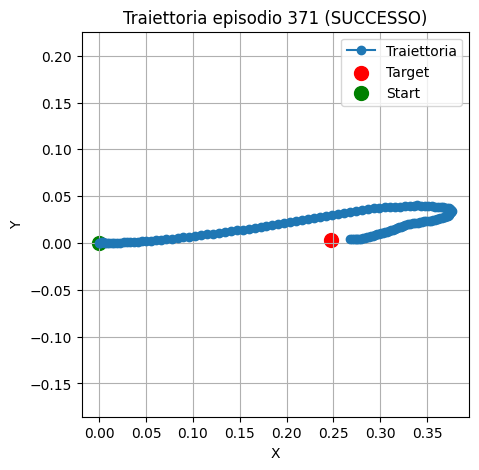

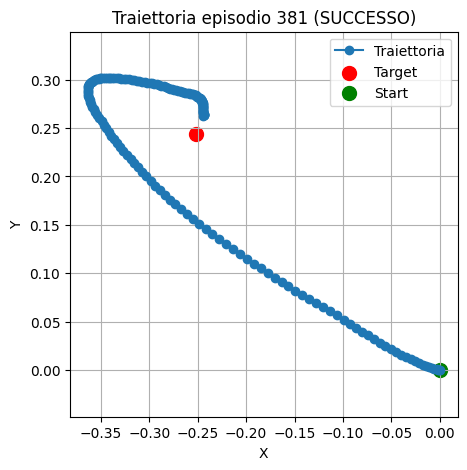

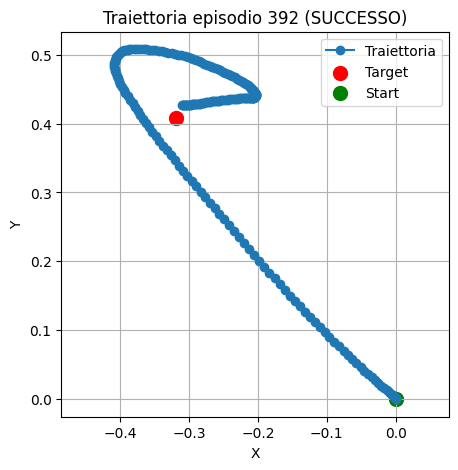

Episode: 400, Step: 135, Counter: 178, Total reward: 758.0548095703125, final state: tensor([ 0.2155, -0.3644,  0.2072, -0.3475])


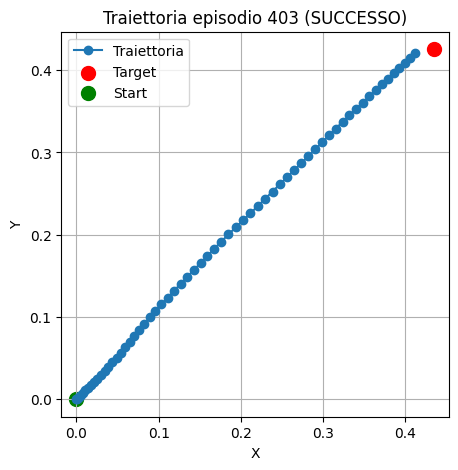

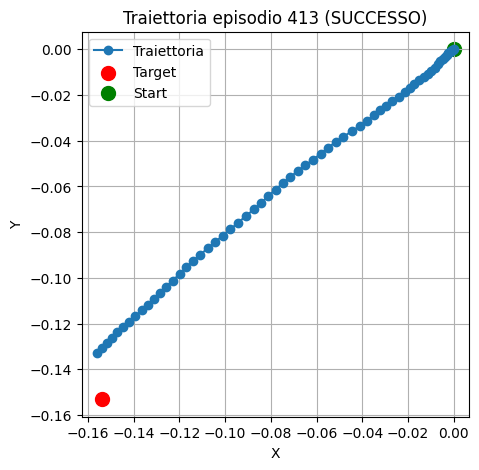

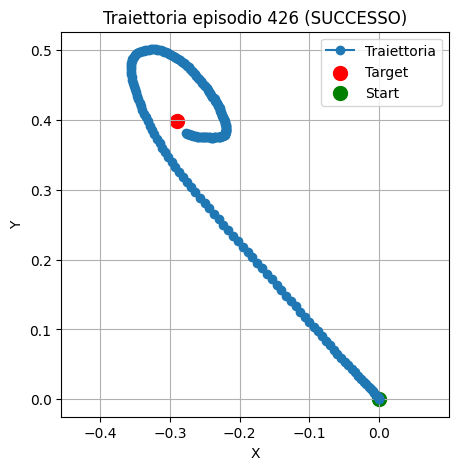

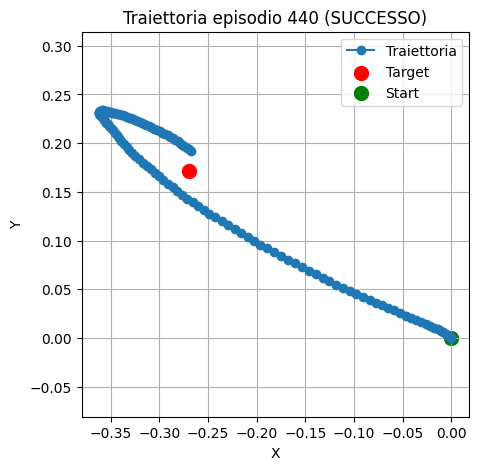

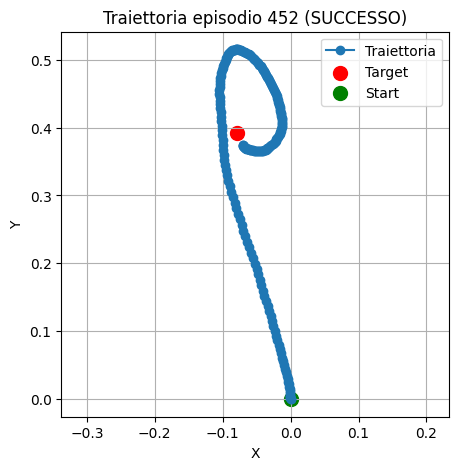

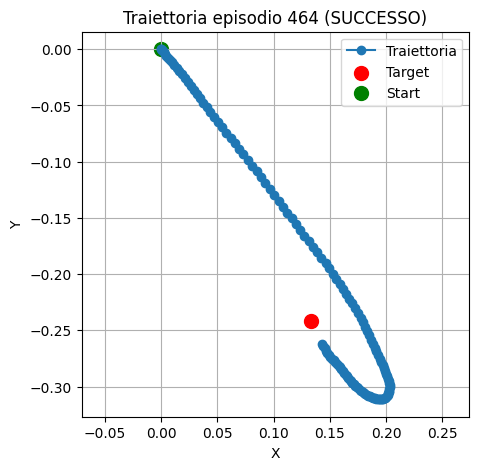

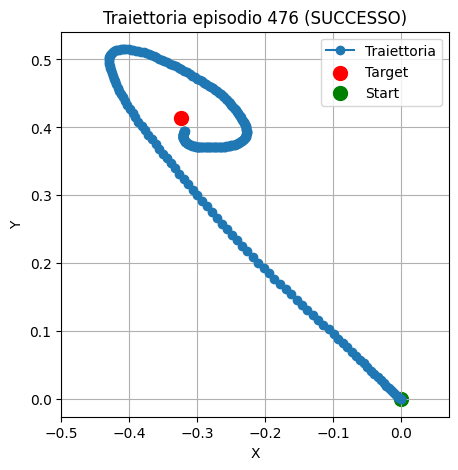

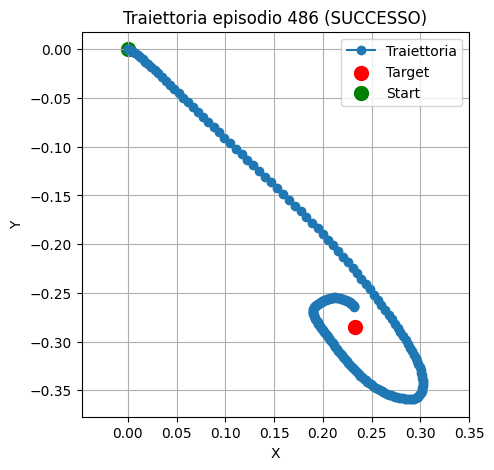

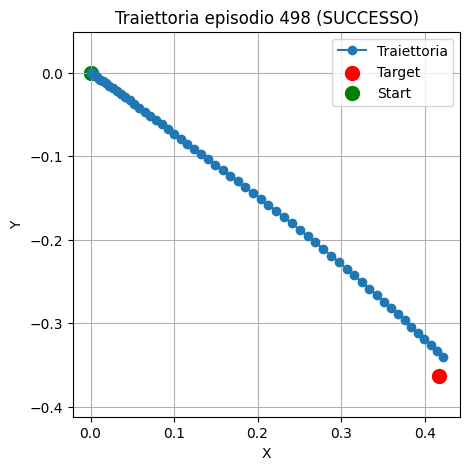

Episode: 500, Step: 47, Counter: 262, Total reward: 704.3297729492188, final state: tensor([-0.3013,  0.0293, -0.3149,  0.0419])


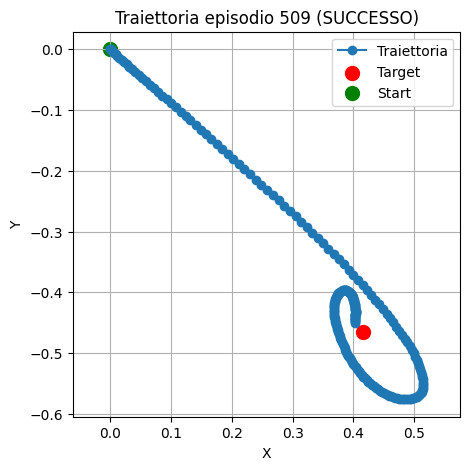

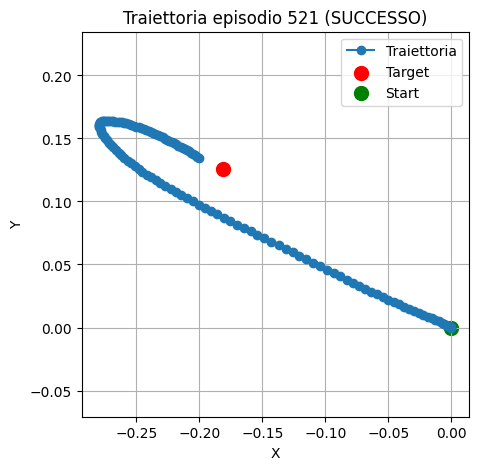

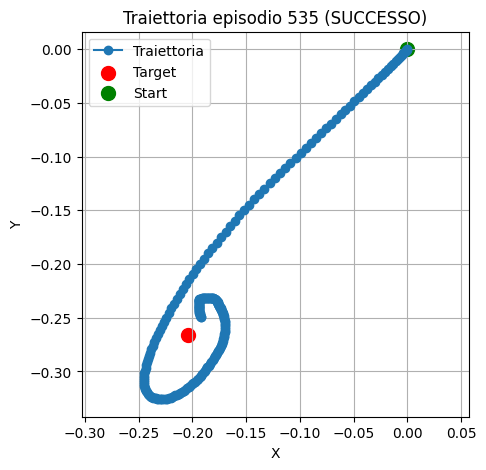

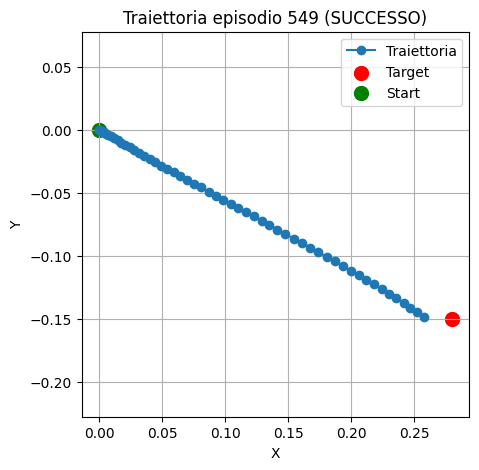

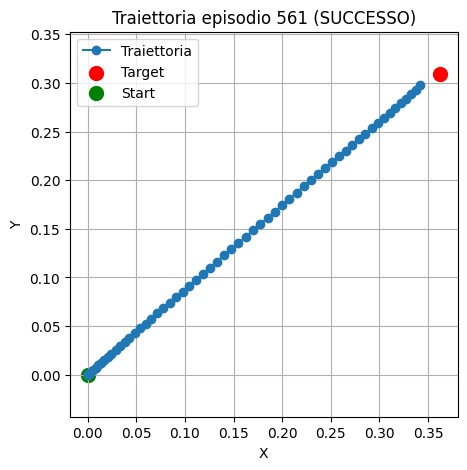

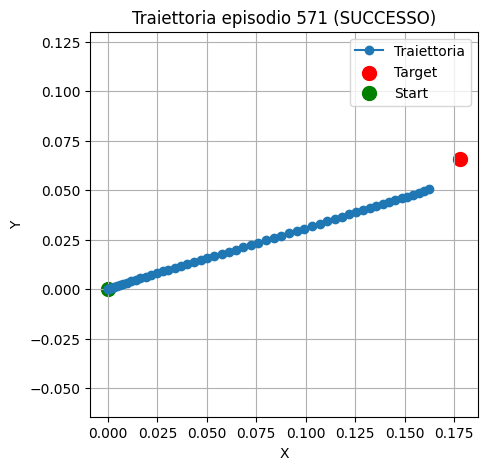

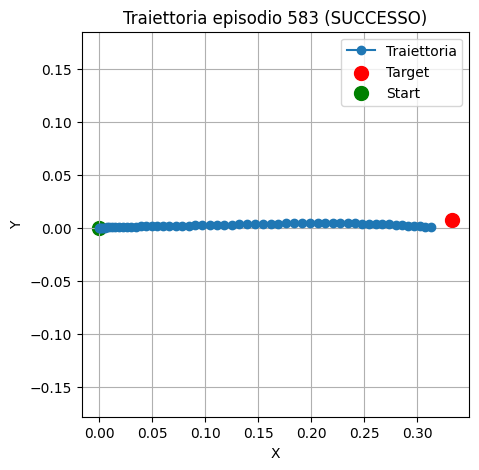

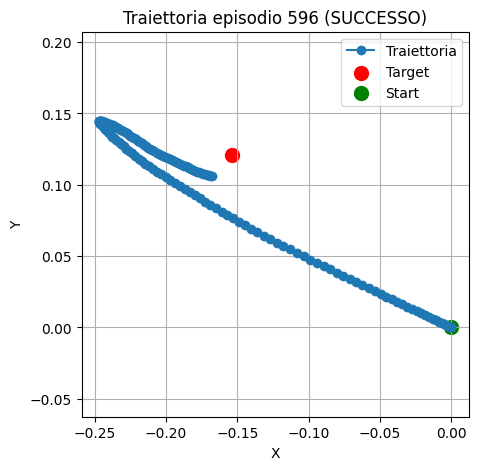

Episode: 600, Step: 131, Counter: 343, Total reward: 904.9754028320312, final state: tensor([ 0.2439, -0.4881,  0.2583, -0.4754])


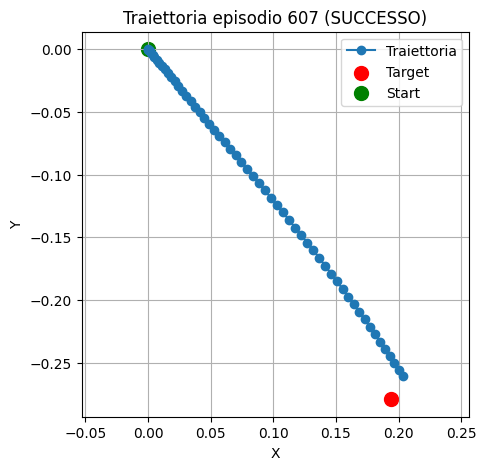

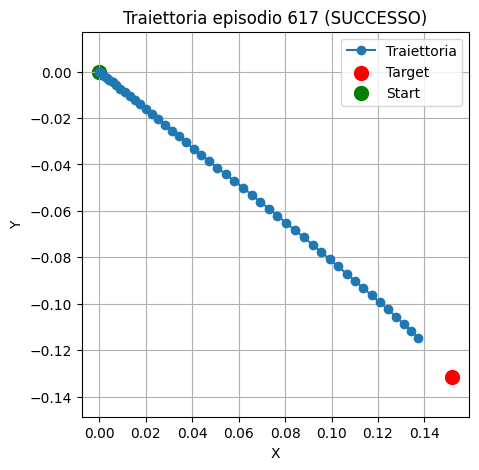

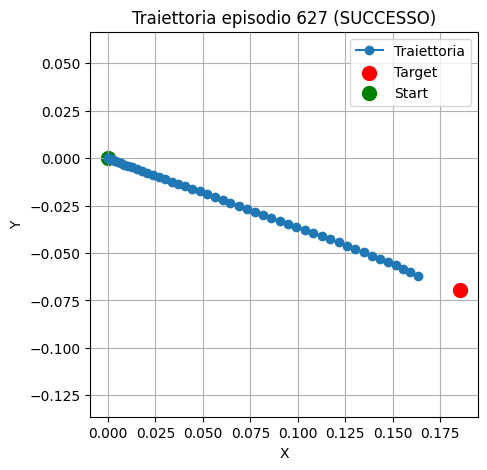

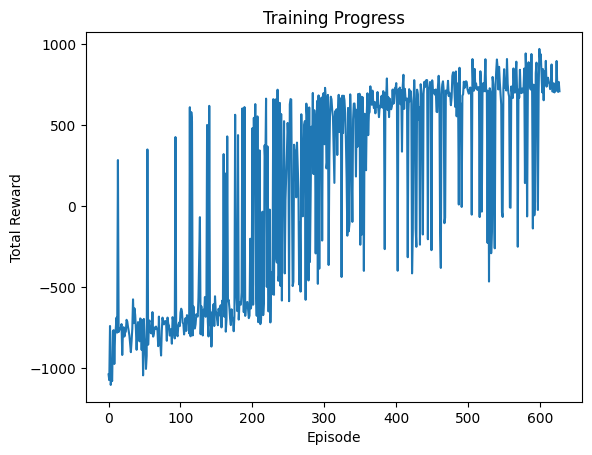

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from environment import TrackingEnv

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

MAX_MEMORY = 1600
NUM_NEURONS = 64
LR_CRITIC = 0.0005
LR_ACTOR = 0.001
GAMMA = 0.99
LAMBDA = 0.95
CLIP_EPS = 0.2
K_EPOCH = 10
EARLY_STOPPING_EPISODES = 30
ENTROPY_COEFF = 0.01

def compute_advantages(rewards, values, dones, gamma=GAMMA, lam=LAMBDA):
    advantages = []
    gae = 0
    values = torch.cat([values, torch.tensor([0], dtype=values.dtype, device=values.device)])  # Append a 0 for the last state
    for t in reversed(range(len(rewards))):
        delta = rewards[t] + gamma * values[t + 1] * (1 - dones[t]) - values[t]
        gae = delta + gamma * lam * (1 - dones[t]) * gae
        advantages.insert(0, gae)
    return torch.tensor(advantages, dtype=torch.float)

def compute_returns(rewards, dones, gamma=0.99):
    returns = []
    G = 0
    for reward, done in zip(reversed(rewards), reversed(dones)):
        G = reward + gamma * G * (1 - done)  # Reset if episode ended
        returns.insert(0, G)
    return returns

class PolicyNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PolicyNet, self).__init__()

        self.noise_std = 0.1
        
        self.fc1 = nn.Linear(state_dim, NUM_NEURONS)
        self.fc2 = nn.Linear(NUM_NEURONS, NUM_NEURONS)
        
        # Output per la media (mu)
        self.mu_layer = nn.Linear(NUM_NEURONS, action_dim)
        
        # Output per la deviazione standard (log_sigma)
        self.log_sigma_layer = nn.Linear(NUM_NEURONS, action_dim)

    def add_noise_to_target(self, state):
        state = state.clone()
        if state.dim() == 1:
            state[2:4] += torch.normal(0.0, self.noise_std, size=(2,), device=state.device)
        else:
            state[:, 2:4] += torch.normal(0.0, self.noise_std, size=state[:, 2:4].shape, device=state.device)
        return state


    def forward(self, state):#, exploration_term):

        #state = self.add_noise_to_target(state)

        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        
        # Media delle azioni
        mu = self.mu_layer(x)
        
        # Deviazione standard (softplus per garantire positività)
        log_sigma = self.log_sigma_layer(x)
        sigma = F.softplus(log_sigma) + 1e-5 # 1e-5 per evitare log(0)
        #sigma = F.softplus(log_sigma) + exploration_term + 1e-5 # 1e-5 per evitare log(0)

        return mu, sigma

class ValueNet(nn.Module):
    def __init__(self, num_inputs):
        super(ValueNet, self).__init__()
        self.fc1 = nn.Linear(num_inputs, NUM_NEURONS)
        self.fc2 = nn.Linear(NUM_NEURONS, NUM_NEURONS)
        self.fc3 = nn.Linear(NUM_NEURONS, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

class PPOAgent(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(PPOAgent, self).__init__()
        self.actor = PolicyNet(num_inputs, num_actions)
        self.critic = ValueNet(num_inputs)
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=LR_CRITIC)
        self.buffer = []
    
    def get_action(self, state):
        mu, sigma = self.actor.forward(state)#, exploration_term)
        dist = torch.distributions.Normal(mu, sigma)
        action = dist.rsample()  # Usa reparametrization trick per il backprop
        log_prob = dist.log_prob(action).sum(dim=-1)  # Somma log-prob per dimensione azione
        return action.detach(), log_prob

    def store_transition(self, transition):
        self.buffer.append(transition)

    # def reward_function(self, state, action, next_state, step, tolerance, rimbalzato):
    #     # Calcola la ricompensa basata sulla distanza tra il primo e il secondo oggetto
    #     distance = torch.norm(next_state[:2] - next_state[2:4])
    #     if distance < tolerance:
    #         reward = 100
    #     else:
    #         reward = -distance.item()
    #     if rimbalzato:
    #         reward += -10
    #     return reward

    def reward_function(self, state, action, next_state, step, tolerance, rimbalzato):

        pos = state[:2]
        target = state[2:4]
        next_pos = next_state[:2]
        #next_pos = torch.tensor(next_pos, dtype=torch.float32)

        to_target = F.normalize(target - pos, dim=0)          # direzione ideale
        action_dir = F.normalize(action, dim=0)               # direzione dell’azione
        direction_reward = torch.dot(action_dir, to_target)   # massimo = 1, minimo = -1

        # Distanze
        dist_before = torch.norm(pos - target)
        dist_after = torch.norm(next_pos - target)
        progress = dist_before - dist_after
        
        step_penalty = 0.01 * step

        #Se raggiunge il target
    
        if dist_after < tolerance:
            reward = 500 - 1 * step if step > 100 else 500
            #reward = 500
        else:
            #reward = "quanto mi avvicino" + "quanto vado nella direzione giusta"
            reward = 2 * progress + 5 * direction_reward  # pesi da tarare 3 2

        if rimbalzato:
            reward += -5

        return reward - step_penalty

        
    
    def update(self):
        torch.autograd.set_detect_anomaly(True)
        states, actions, rewards, dones, old_log_probs = zip(*self.buffer)
        old_log_probs = torch.stack(old_log_probs)
        states = torch.stack(states)
        actions = torch.stack(actions).float()
        rewards = torch.tensor(rewards, dtype=torch.float32)
        dones = torch.tensor(dones, dtype=torch.float32)
        values = self.critic(states).squeeze()
        advantages = compute_advantages(rewards, values.detach(), dones)
        returns = compute_returns(rewards, dones)  # Compute Monte Carlo returns
        returns = torch.tensor(returns, dtype=torch.float32)
        
        for _ in range(K_EPOCH):
            means, stds = self.actor(states)
            dist = torch.distributions.Normal(means, stds)
            entropy = dist.entropy().sum(dim=-1).mean()  # media sull’intero batch
            new_log_probs = dist.log_prob(actions).sum(dim=-1)
            ratio = torch.exp(new_log_probs - old_log_probs.detach())
            surr1 = ratio * advantages
            surr2 = torch.clamp(ratio, 1-CLIP_EPS, 1+CLIP_EPS) * advantages
            policy_loss = -torch.min(surr1, surr2).mean() - ENTROPY_COEFF * entropy
            values_pred =self.critic(states).squeeze()
            value_loss = F.mse_loss(values_pred, returns)

            total_loss = policy_loss + value_loss

            self.optimizer_actor.zero_grad()
            self.optimizer_critic.zero_grad()
            #policy_loss.backward()
            #value_loss.backward()
            total_loss.backward()
            self.optimizer_actor.step()
            self.optimizer_critic.step()
        
        self.buffer.clear()

def train_ppo(env=None, num_episodes=10000):
    if env is None:
        env = TrackingEnv()
    num_inputs = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]
    agent = PPOAgent(num_inputs, num_actions)
    reward_history = []
    success_history = []
    counter = 0
    tolerance = 0.02 #0.05
    
    for episode in range(num_episodes):
        target = np.random.uniform(-0.5, 0.5, size=(2,))
        target = torch.tensor(target, dtype=torch.float32)
        state, _ = env.reset(target=target)
        done = False
        total_reward = 0
        state = torch.tensor(state, dtype=torch.float32)
        trajectory = []
        step = 0
        
        while not done:
            step += 1
            trajectory.append(state.detach().numpy())
            action, log_prob = agent.get_action(state)
            next_state, _, done, truncated, _, rimbalzato = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32)
            if torch.norm(next_state[:2] - next_state[2:4])<tolerance or truncated:
                done = True
            reward = agent.reward_function(state, action, next_state, step, tolerance, rimbalzato)
            agent.store_transition((state, action, reward, done, log_prob))
            state = next_state
            total_reward += reward
        
        if torch.norm(next_state[:2] - next_state[2:4])<tolerance:
            counter += 1
            success_history.append(1)
            # PLOTTING TRAIETTORIA A SUCCESSO
            trajectory = np.array(trajectory)
            target = next_state[2:4].detach().numpy()

            #print(f"Episode: {episode}, Step: {step}, Counter: {counter}, Total reward: {total_reward}, final state: {state}")

            if counter % 10 == 0:

                plt.figure(figsize=(5, 5))
                plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o', label="Traiettoria")
                plt.scatter(*target, color='red', label='Target', s=100)
                plt.scatter(trajectory[0, 0], trajectory[0, 1], color='green', label='Start', s=100)
                plt.title(f"Traiettoria episodio {episode} (SUCCESSO)")
                plt.xlabel("X")
                plt.ylabel("Y")
                plt.legend()
                plt.grid()
                plt.axis('equal')
                plt.show()

        else:
            success_history.append(0)

        reward_history.append(total_reward)

        if episode % 100 == 0:
            print(f"Episode: {episode}, Step: {step}, Counter: {counter}, Total reward: {total_reward}, final state: {state}")

        # if total_reward > 0:

        #     trajectory = np.array(trajectory)
        #     target = next_state[2:4].detach().numpy()  # x_target, y_target

        #     plt.figure(figsize=(5, 5))
        #     plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o', label="Traiettoria")
        #     plt.scatter(*target, color='red', label='Target', s=100)
        #     plt.scatter(trajectory[0, 0], trajectory[0, 1], color='green', label='Start', s=100)
        #     plt.title(f"Traiettoria episodio {episode}")
        #     plt.xlabel("X")
        #     plt.ylabel("Y")
        #     plt.legend()
        #     plt.grid()
        #     plt.axis('equal')
        #     plt.show()
        
        if len(reward_history)>EARLY_STOPPING_EPISODES and all(s == 1 for s in success_history[-EARLY_STOPPING_EPISODES:]):
            break

        if len(agent.buffer) >= MAX_MEMORY:
            agent.update()
    
    env.close()

    plt.plot(reward_history)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Training Progress')
    plt.show()


    return agent

if __name__ == "__main__":
    trained_agent = train_ppo()


[Episode 0] Steps: 132, Final distance: 0.0175


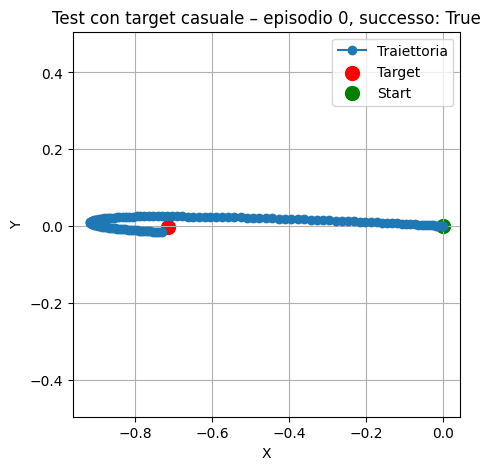

[Episode 1] Steps: 61, Final distance: 0.0160


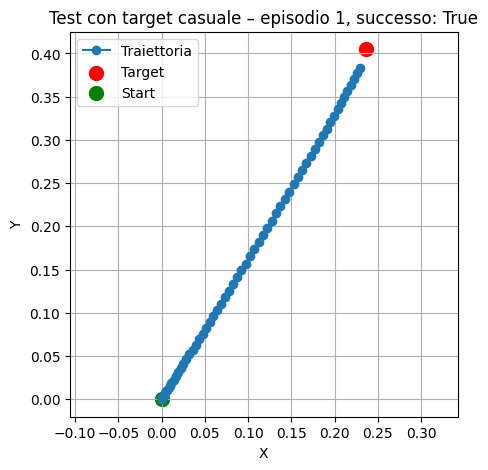

[Episode 2] Steps: 400, Final distance: 0.2160


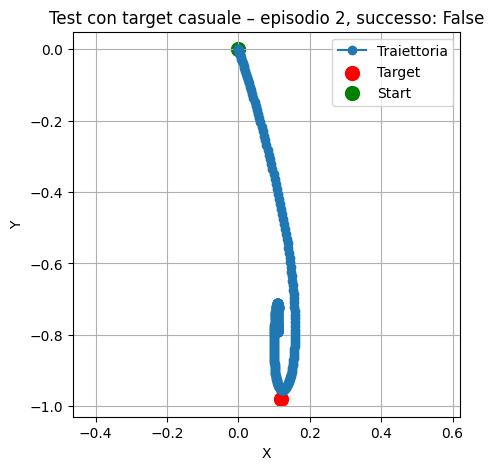

[Episode 3] Steps: 48, Final distance: 0.0167


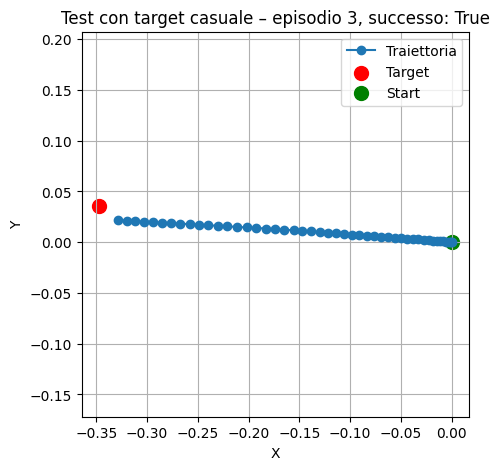

[Episode 4] Steps: 127, Final distance: 0.0185


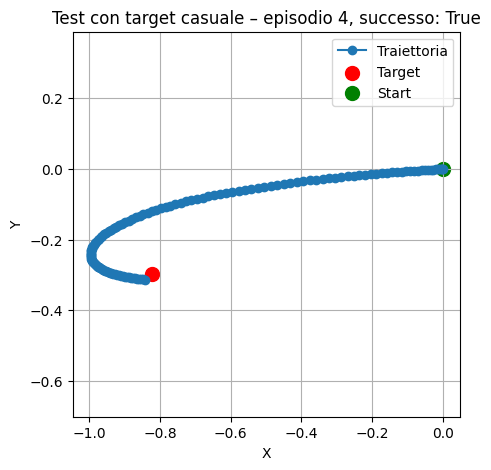

[Episode 5] Steps: 400, Final distance: 0.1855


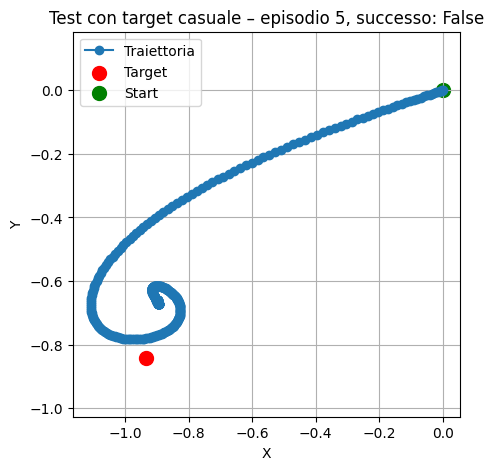

[Episode 6] Steps: 400, Final distance: 0.1469


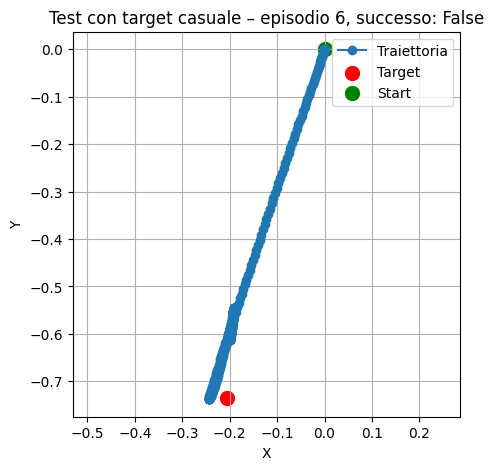

[Episode 7] Steps: 60, Final distance: 0.0174


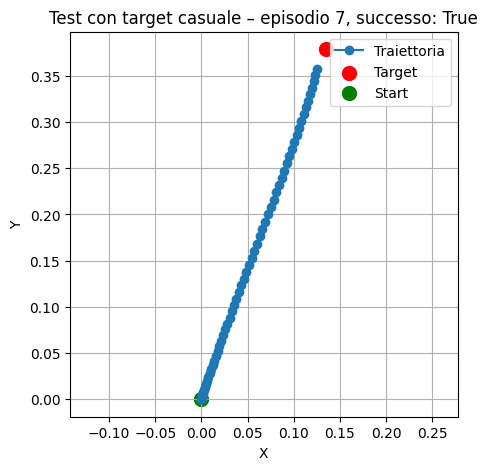

[Episode 8] Steps: 400, Final distance: 0.0802


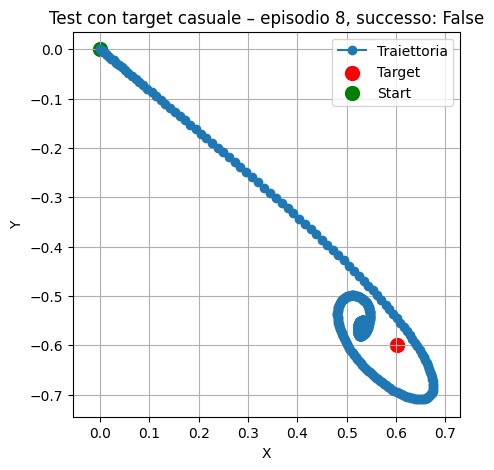

[Episode 9] Steps: 400, Final distance: 0.1556


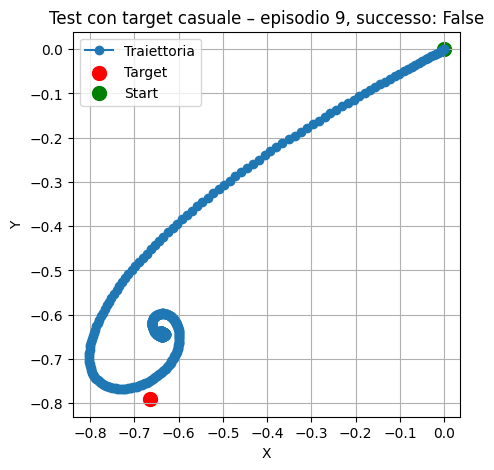

In [4]:
def test_agent_with_random_targets(agent, env=None, num_episodes=10, target_sampler=None, tolerance=0.02):
    if env is None:
        env = TrackingEnv()

    agent.eval()

    for ep in range(num_episodes):
        # Genera un target casuale (es. all’interno di uno spazio 2D limitato)
        if target_sampler:
            target = target_sampler()
            target = torch.tensor(target, dtype=torch.float32)
        else:
            target = np.random.uniform(low=-1.0, high=1.0, size=(2,))  # Default sampler
            target = torch.tensor(target, dtype=torch.float32)

        # Reset con target personalizzato (modifica TrackingEnv se necessario)
        state, _ = env.reset(target=target)
        state = torch.tensor(state, dtype=torch.float32)

        done = False
        step = 0
        trajectory = []

        while not done:
            trajectory.append(state.detach().numpy())
            action, _ = agent.get_action(state)
            next_state, _, done, truncated, _, rimbalzato = env.step(action)
            next_state = torch.tensor(next_state, dtype=torch.float32)
            if torch.norm(next_state[:2] - next_state[2:4]) < tolerance or truncated:
                done = True
            state = next_state
            step += 1

        trajectory = np.array(trajectory)
        final_dist = np.linalg.norm(state[:2] - state[2:4])
        print(f"[Episode {ep}] Steps: {step}, Final distance: {final_dist:.4f}")

        success = False

        if final_dist < tolerance:
            success = True

        plt.figure(figsize=(5, 5))
        plt.plot(trajectory[:, 0], trajectory[:, 1], marker='o', label="Traiettoria")
        plt.scatter(*state[2:4], color='red', label='Target', s=100)
        plt.scatter(trajectory[0, 0], trajectory[0, 1], color='green', label='Start', s=100)
        plt.title(f"Test con target casuale – episodio {ep}, successo: {success}")
        plt.xlabel("X")
        plt.ylabel("Y")
        plt.legend()
        plt.grid()
        plt.axis('equal')
        plt.show()

    env.close()

def target_sampler():
    # Genera target in un quadrato [-1, 1] x [-1, 1]
    return np.random.uniform(low=-1, high=1, size=(2,))


test_agent_with_random_targets(trained_agent, target_sampler=target_sampler)